In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation
from sklearn.cluster import KMeans
from scipy.ndimage import label

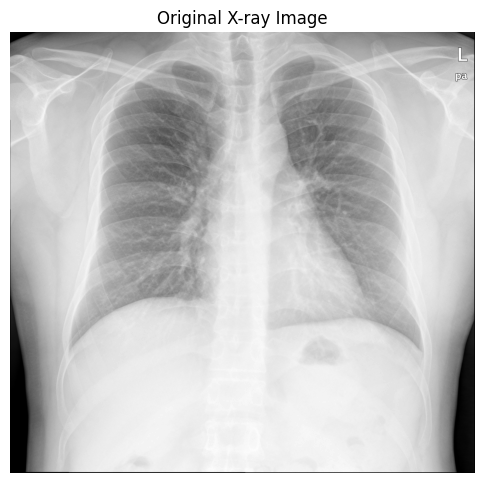

In [2]:
# Load and display sample images from dataset
data_dir = "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png"
image_files = [f for f in os.listdir(data_dir) if f.endswith(".png")]

# Load one sample image
sample_image_path = os.path.join(data_dir, image_files[0])
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,6))
plt.imshow(sample_image, cmap='gray')
plt.title("Original X-ray Image")
plt.axis("off")
plt.show()

Unique values in gt_mask: [  0 255]


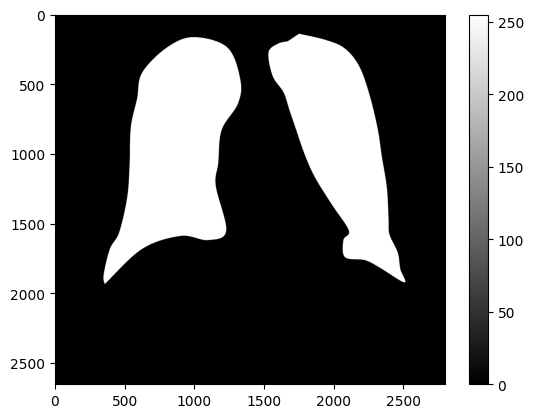

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load your ground truth mask (make sure it's grayscale)
gt_mask = cv2.imread("/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/masks/CHNCXR_0092_0_mask.png", cv2.IMREAD_GRAYSCALE)

# Debug: Print unique values in gt_mask
print("Unique values in gt_mask:", np.unique(gt_mask))

# Display the mask
plt.imshow(gt_mask, cmap="gray")
plt.colorbar()
plt.show()


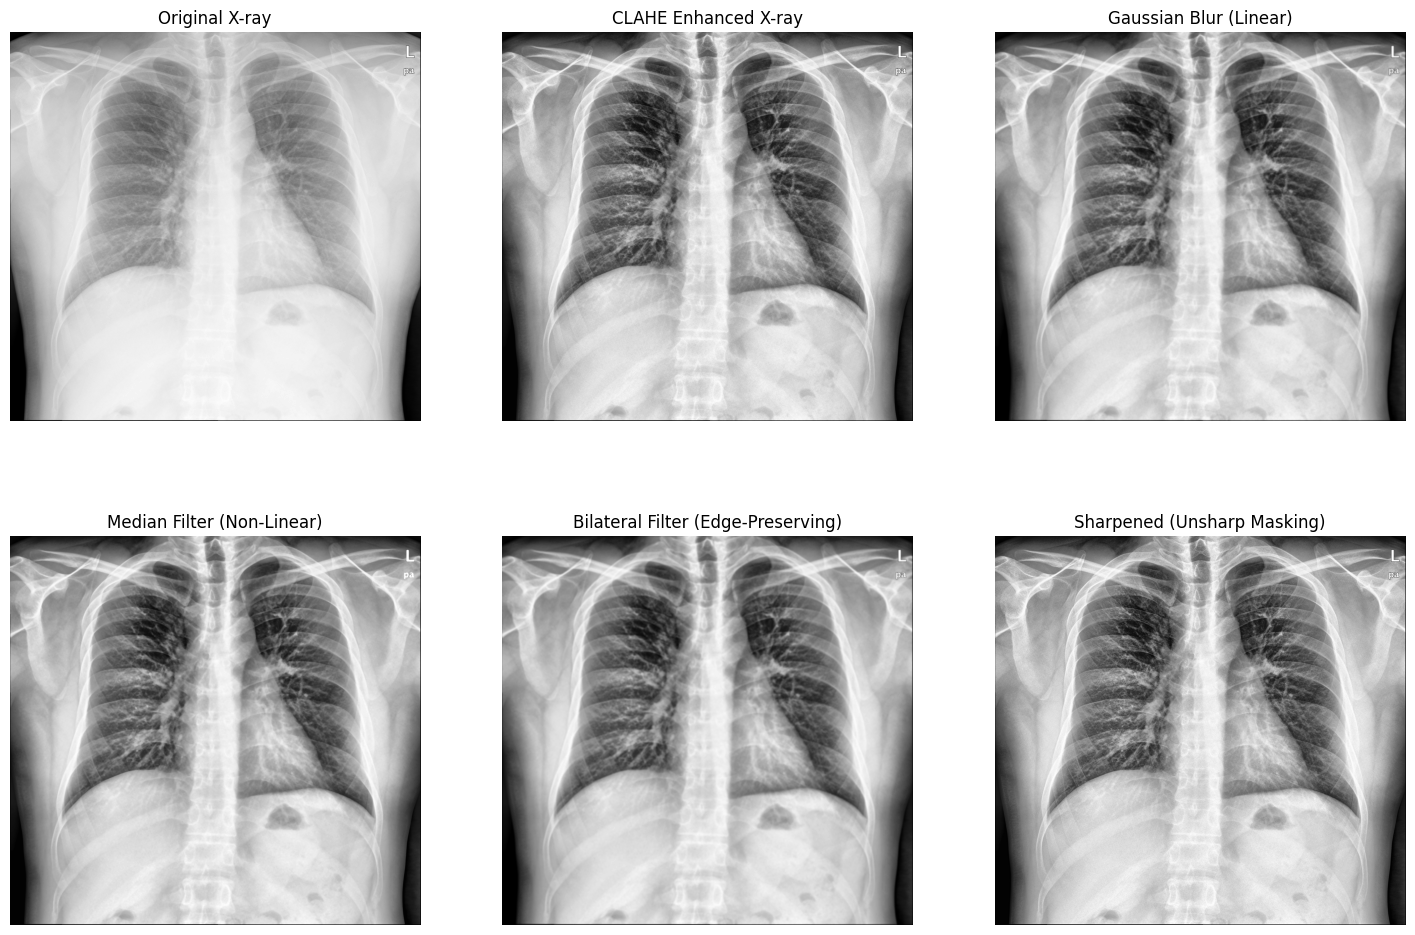

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load X-ray image (Ensure it's grayscale)
xray_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
xray_image_eq = clahe.apply(xray_image)

# Apply Gaussian Blur (Linear)
gaussian_blur = cv2.GaussianBlur(xray_image_eq, (15, 15), 0)

# Apply Median Filter (Non-Linear)
median_blur = cv2.medianBlur(xray_image_eq, 9)

# Apply Bilateral Filter (Edge-preserving)
bilateral_blur = cv2.bilateralFilter(xray_image_eq, 15, 150, 150)

# Apply Unsharp Masking for Edge Enhancement
sharp = cv2.addWeighted(xray_image_eq, 1.5, gaussian_blur, -0.5, 0)

# Display results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(xray_image, cmap="gray")
axes[0, 0].set_title("Original X-ray")
axes[0, 0].axis("off")

axes[0, 1].imshow(xray_image_eq, cmap="gray")
axes[0, 1].set_title("CLAHE Enhanced X-ray")
axes[0, 1].axis("off")

axes[0, 2].imshow(gaussian_blur, cmap="gray")
axes[0, 2].set_title("Gaussian Blur (Linear)")
axes[0, 2].axis("off")

axes[1, 0].imshow(median_blur, cmap="gray")
axes[1, 0].set_title("Median Filter (Non-Linear)")
axes[1, 0].axis("off")

axes[1, 1].imshow(bilateral_blur, cmap="gray")
axes[1, 1].set_title("Bilateral Filter (Edge-Preserving)")
axes[1, 1].axis("off")

axes[1, 2].imshow(sharp, cmap="gray")
axes[1, 2].set_title("Sharpened (Unsharp Masking)")
axes[1, 2].axis("off")

plt.show()


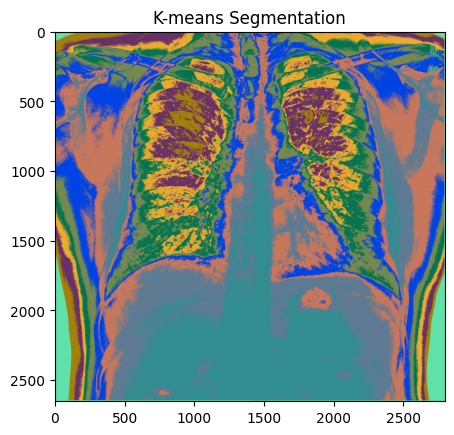

IoU (Sklearn Jaccard): 0.3036
Dice Coefficient (F1 Score): 0.4658
Precision: 0.3639
Recall: 0.6468
Pixel Accuracy: 0.6372


In [9]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, jaccard_score, f1_score
import matplotlib.pyplot as plt

# Load the image
sample_image_path = os.path.join(data_dir, image_files[0])  # Ensure `data_dir` and `image_files` are defined
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
sampled_image = cv2.GaussianBlur(sample_image, (5,5), 0)
# Flatten the image into a 2D array (height * width, 3 channels)
flat_image = sample_image.reshape((-1, 3))

# Perform K-means clustering
kmeans = KMeans(n_clusters=10,n_init=10, random_state=42)  # Choose the number of clusters (4 in this case)
kmeans.fit(flat_image)  # Apply K-means clustering on the RGB pixel values
labels = kmeans.labels_

# Reshape the labels to the original image shape
segmented_image = labels.reshape(sample_image.shape[:2])

# Generate a colored segmented image
unique_labels = np.unique(labels)
segmented_colors = np.random.randint(0, 255, size=(len(unique_labels), 3))
colored_segmented_image = segmented_colors[segmented_image]

# Visualize the segmented image
plt.imshow(colored_segmented_image)
plt.title("K-means Segmentation")
plt.show()

# Assume ground truth (gt_mask) is available as a binary mask
# Convert ground truth and segmented images to binary
gt_binary = (gt_mask > 128).astype(np.uint8).flatten()

# Normalize segmented image and convert to binary
segmented_norm = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min()) * 255
segmented_binary = (segmented_norm > 128).astype(np.uint8).flatten()

# Compute Precision, Recall, IoU (Jaccard), Dice (F1 Score), and Pixel Accuracy using sklearn
precision = precision_score(gt_binary, segmented_binary)
recall = recall_score(gt_binary, segmented_binary)
iou_sklearn = jaccard_score(gt_binary, segmented_binary)  # Same as IoU
dice = f1_score(gt_binary, segmented_binary)  # Dice coefficient is F1-score

# Compute Pixel Accuracy
pixel_accuracy = np.sum(gt_binary == segmented_binary) / len(gt_binary)

# Print results
print(f"IoU (Sklearn Jaccard): {iou_sklearn:.4f}")
print(f"Dice Coefficient (F1 Score): {dice:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")


In [10]:
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from google.colab.patches import cv2_imshow
# Load the image
sample_image_path = os.path.join(data_dir, image_files[0])
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sampled_image = cv2.GaussianBlur(sample_image, (5,5), 0)
#Convert image to L*a*b* color space 
lab_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2LAB)

# Flatten the image
flat_image = lab_image.reshape((-1, 3))

# Create the feature space [L, a, b, x, y]
height, width, _ = sample_image.shape
x, y = np.meshgrid(np.arange(width), np.arange(height))
flat_image_with_coordinates = np.column_stack([flat_image, x.flatten(), y.flatten()])

# Perform Mean Shift clustering
mean_shift = MeanShift(bandwidth=33.11334733910179, bin_seeding=True)
mean_shift.fit(flat_image_with_coordinates)
labels = mean_shift.labels_

# Reshape the labels to the original image shape
segmented_image = labels.reshape((height, width))

# Generate a colored segmented image
unique_labels = np.unique(labels)
segmented_colors = np.random.randint(0, 255, size=(len(unique_labels), 3))
colored_segmented_image = segmented_colors[segmented_image]

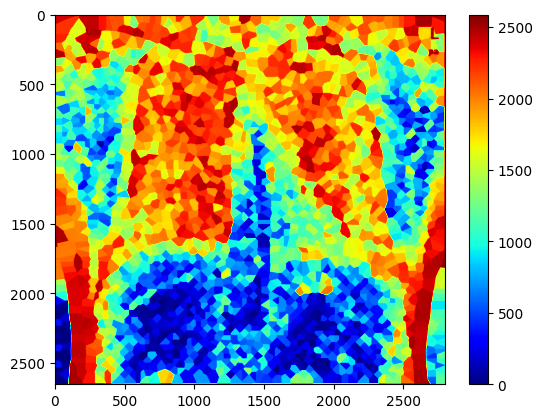

In [11]:
plt.imshow(segmented_image,cmap="jet")
plt.colorbar()
plt.show()

In [13]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, jaccard_score, f1_score

# Convert ground truth and segmented images to binary
gt_binary = (gt_mask > 128).astype(np.uint8).flatten()
segmented_norm = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min()) * 255
segmented_binary = (segmented_norm > 128).astype(np.uint8).flatten()


# Compute Precision, Recall, IoU (Jaccard), and Dice (F1 Score) using sklearn
precision = precision_score(gt_binary, segmented_binary)
recall = recall_score(gt_binary, segmented_binary)
iou_sklearn = jaccard_score(gt_binary, segmented_binary)  # Same as IoU
dice = f1_score(gt_binary, segmented_binary)  # Dice coefficient is F1-score
pixel_accuracy = np.mean(gt_binary == segmented_binary)

# Print Pixel Accuracy
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"IoU (Sklearn Jaccard): {iou_sklearn:.4f}")
print(f"Dice Coefficient (F1 Score): {dice:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Pixel Accuracy: 0.6659
IoU (Sklearn Jaccard): 0.4198
Dice Coefficient (F1 Score): 0.5913
Precision: 0.4218
Recall: 0.9887


IoU Score: 0.4378
Precision: 0.7105
Recall: 0.5328
Dice Coefficient (F1-score): 0.6090
Pixel Accuracy: 0.8327


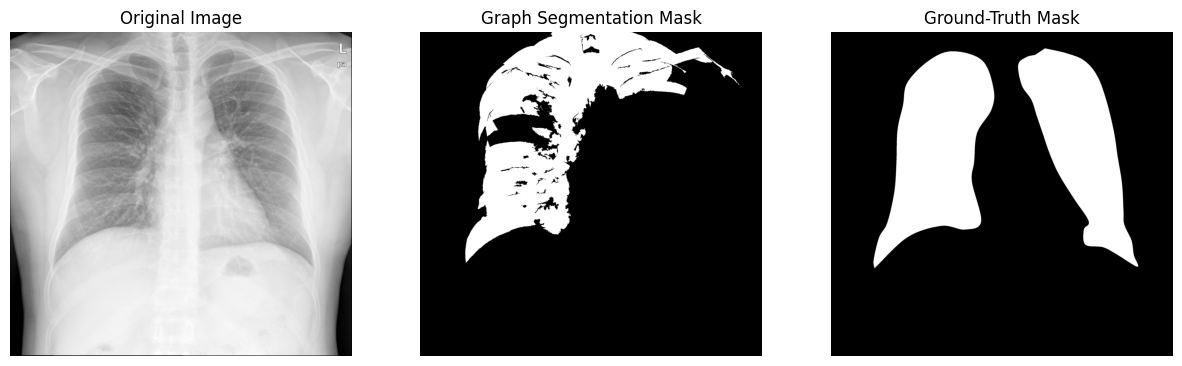

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.segmentation import felzenszwalb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define directories
data_dir = "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png"
mask_dir = "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/masks"

# List images
image_files = [f for f in os.listdir(data_dir) if f.endswith(".png")]

# Select a sample image and its corresponding mask
sample_image_path = os.path.join(data_dir, image_files[0])
mask_path = os.path.join(mask_dir, image_files[0].replace(".png", "_mask.png"))

# Load images
image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load ground-truth mask in grayscale

# Function for graph segmentation
def graph_segmentation(image, scale=100, min_size=500):
    segments = felzenszwalb(image, scale=scale, min_size=min_size)
    unique, counts = np.unique(segments, return_counts=True)
    
    sorted_counts = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)
    lesion_label = sorted_counts[1][0] if len(sorted_counts) > 1 else sorted_counts[0][0]
    
    binary_mask = (segments == lesion_label).astype(np.uint8) * 255
    return binary_mask

# Generate segmentation mask
segmentation_mask = graph_segmentation(image)

# Convert masks to binary
segmentation_mask = (segmentation_mask > 0).astype(np.uint8)
gt_mask = (gt_mask > 0).astype(np.uint8)

# Flatten masks for metric calculation
pred_flat = segmentation_mask.flatten()
gt_flat = gt_mask.flatten()

# IoU (Intersection over Union) Calculation
def iou_score(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0

iou = iou_score(pred_flat, gt_flat)

# Compute additional metrics
precision = precision_score(gt_flat, pred_flat, average='binary', zero_division=1)
recall = recall_score(gt_flat, pred_flat, average='binary', zero_division=1)
dice = f1_score(gt_flat, pred_flat, average='binary')  # Dice is the same as F1-score
pixel_accuracy = accuracy_score(gt_flat, pred_flat)

# Print metrics
print(f"IoU Score: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Dice Coefficient (F1-score): {dice:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(segmentation_mask, cmap="gray")
axes[1].set_title("Graph Segmentation Mask")
axes[1].axis("off")

axes[2].imshow(gt_mask, cmap="gray")
axes[2].set_title("Ground-Truth Mask")
axes[2].axis("off")

plt.show()
